Reading data from datasets/Gene-Classification.csv...
Data preview:
                   Unnamed: 0                 Classification  \
0                        Gene  aminocoumarin resistance gene   
1  AAC(6')-Ic,f,g,h,j,k,l,r-z                              0   
2                  AAC(6')-Iy                              0   
3                        acrA                              0   
4                  AcrAB-TolC                              0   

                       Unnamed: 2  \
0  aminoglycoside resistance gene   
1                               0   
2                               0   
3                               0   
4                               0   

                                          Unnamed: 3  \
0  aminoglycoside resistance gene,antibiotic inac...   
1                                                  0   
2                                                 32   
3                                                  0   
4                                           

C:\Users\Fatima\AppData\Local\Temp\ipykernel_26364\1003694231.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.issubdtype(heatmap_df.dtypes[0], np.number):


Heatmap saved to GeneClassification_heatmap.png with resolution 300 DPI

Exporting heatmap matrix data to CSV...
Matrix data exported to GeneClassification_matrix.csv
Label reference file generated: GeneClassification_reference.txt

Heatmap generation complete.


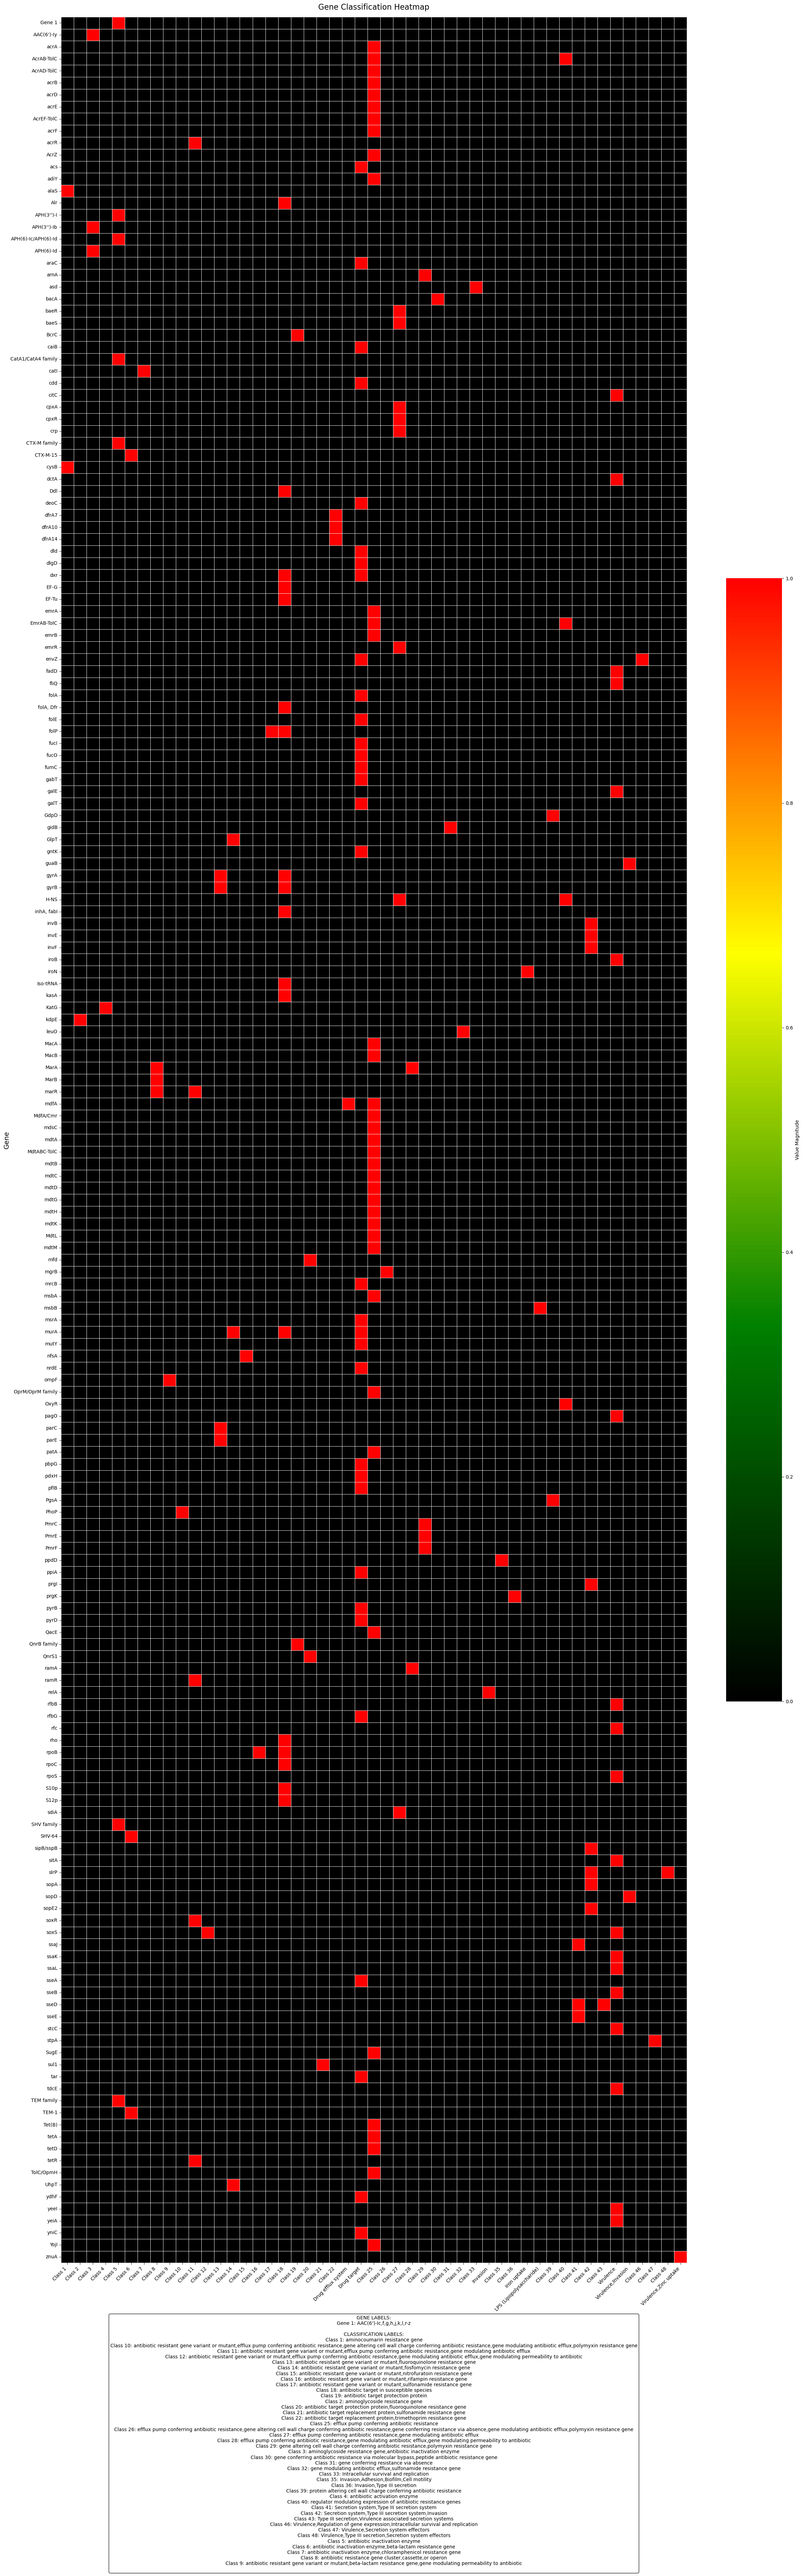

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
input_file = "datasets/Gene-Classification.csv"
output_heatmap = "GeneClassification_heatmap.png"
output_reference = "GeneClassification_reference.txt"
output_matrix_csv = "GeneClassification_matrix.csv"

# Data acquisition and preprocessing
print(f"Reading data from {input_file}...")
data = pd.read_csv(input_file)

# Examine data structure
print("Data preview:")
print(data.head())

# Determine the CSV structure
# Approach 1: If first row contains classifications as headers
if data.iloc[0, 0] == 'Gene':
    print("First row contains classification headers")
    # Extract classifications from the first row
    classifications = data.iloc[0, 1:].tolist()
    class_names = [str(cls) for cls in classifications]
    
    # Extract gene names from first column (excluding header row)
    genes = data.iloc[1:, 0].tolist()
    
    # Extract the numeric data (excluding the header row and first column)
    matrix_data = data.iloc[1:, 1:].values
    
    # Convert to numeric where possible, handling errors
    try:
        matrix_data = matrix_data.astype(float)
    except ValueError:
        # Alternative approach for mixed data types
        print("Warning: Mixed data types detected in matrix. Attempting conversion...")
        # Create a mask of convertible values
        mask = np.ones_like(matrix_data, dtype=bool)
        numeric_matrix = np.zeros_like(matrix_data, dtype=float)
        
        # Convert elements individually where possible
        for i in range(matrix_data.shape[0]):
            for j in range(matrix_data.shape[1]):
                try:
                    numeric_matrix[i,j] = float(matrix_data[i,j])
                except (ValueError, TypeError):
                    mask[i,j] = False
                    numeric_matrix[i,j] = 0  # Default value for non-convertible cells
        
        # Report conversion statistics
        print(f"Converted {np.sum(mask)}/{matrix_data.size} values to numeric format")
        matrix_data = numeric_matrix
    
# Approach 2: If first column is already gene names and columns are classifications
else:
    print("Data appears to be in standard format")
    # First column contains gene names
    genes = data.iloc[:, 0].tolist()
    
    # Column headers (excluding first) are classifications
    class_names = data.columns[1:].tolist()
    
    # Matrix data is everything except first column
    matrix_data = data.iloc[:, 1:].values
    
    # Convert to numeric where possible, handling errors
    try:
        matrix_data = matrix_data.astype(float)
    except ValueError:
        # Alternative approach for mixed data types
        print("Warning: Mixed data types detected in matrix. Attempting conversion...")
        # Create a mask of convertible values
        mask = np.ones_like(matrix_data, dtype=bool)
        numeric_matrix = np.zeros_like(matrix_data, dtype=float)
        
        # Convert elements individually where possible
        for i in range(matrix_data.shape[0]):
            for j in range(matrix_data.shape[1]):
                try:
                    numeric_matrix[i,j] = float(matrix_data[i,j])
                except (ValueError, TypeError):
                    mask[i,j] = False
                    numeric_matrix[i,j] = 0  # Default value for non-convertible cells
        
        # Report conversion statistics
        print(f"Converted {np.sum(mask)}/{matrix_data.size} values to numeric format")
        matrix_data = numeric_matrix

print(f"Extracted {len(genes)} genes and {len(class_names)} classifications")
print(f"Matrix shape: {matrix_data.shape}")

# Check for any data issues
try:
    # This may fail if data isn't all numeric
    non_zero_count = np.count_nonzero(matrix_data)
    print(f"Data contains {non_zero_count} non-zero values out of {matrix_data.size}")
    print(f"Unique values in data: {np.unique(matrix_data)[:10]}...")
except:
    print("Warning: Matrix contains non-numeric values")
    # Count non-zero/non-empty cells another way
    non_empty = np.sum(matrix_data != 0) if hasattr(matrix_data, 'shape') else sum(1 for x in matrix_data.flatten() if x != 0)
    print(f"Data contains {non_empty} non-zero/non-empty values")

# Handle long gene names by creating shortened names if needed
gene_label_mapping = {}
for idx, gene in enumerate(genes):
    if len(str(gene)) > 25:  # Threshold for truncation
        shortened = f"Gene {idx+1}"  # Numeric identifier
        gene_label_mapping[shortened] = str(gene)
        genes[idx] = shortened

# Handle long classification names by creating shortened names if needed
class_label_mapping = {}
for idx, cls in enumerate(class_names):
    if len(str(cls)) > 25:  # Threshold for truncation
        shortened = f"Class {idx+1}"  # Numeric identifier
        class_label_mapping[shortened] = str(cls)
        class_names[idx] = shortened

# Figure dimensioning with optimization for data volume
fig_width = max(20, len(class_names) * 0.5)
fig_height = max(14, len(genes) * 0.4)

# Create the heatmap visualization
print("\nGenerating heatmap visualization...")
plt.figure(figsize=(fig_width, fig_height))

# Try to convert data to DataFrame with appropriate handling of potential issues
try:
    heatmap_df = pd.DataFrame(matrix_data, index=genes, columns=class_names)
    
    # If data is not numeric, attempt to convert
    if not np.issubdtype(heatmap_df.dtypes[0], np.number):
        # Try to convert to numeric, coercing errors to NaN
        heatmap_df = heatmap_df.apply(pd.to_numeric, errors='coerce')
        
        # Replace NaN with 0 for visualization
        heatmap_df = heatmap_df.fillna(0)
        
        print("Converted non-numeric data to numeric format for visualization")
except Exception as e:
    print(f"Error creating dataframe: {e}")
    # Fallback: create a simplified dataframe
    print("Creating simplified dataframe for visualization")
    try:
        # Try to create a binary heatmap (0 = absent, 1 = present)
        binary_matrix = np.where(matrix_data != 0, 1, 0)
        heatmap_df = pd.DataFrame(binary_matrix, index=genes, columns=class_names)
    except:
        print("Severe data structure issue - attempting to visualize what we can")
        # Extract whatever subset of data we can work with
        max_genes = min(50, len(genes))  # Limit to 50 genes max
        max_classes = min(20, len(class_names))  # Limit to 20 classes max
        
        # Create a subset dataframe
        subset_matrix = np.zeros((max_genes, max_classes))
        heatmap_df = pd.DataFrame(
            subset_matrix, 
            index=genes[:max_genes], 
            columns=class_names[:max_classes]
        )
        print(f"Created subset visualization with {max_genes} genes and {max_classes} classifications")

# Custom color gradient: black for zero, green to red for increasing values
cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
    "custom", ["black", "green", "yellow", "red"], N=256
)

# Determine appropriate annotation parameters based on data size
show_annotations = len(genes) * len(class_names) <= 500  # Only show annotations for smaller matrices
annot_kws = {"size": 9} if len(genes) * len(class_names) <= 200 else {"size": 7}

# Generate the heatmap
heatmap = sns.heatmap(
    heatmap_df,
    cmap=cmap,
    cbar=True,
    square=False,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    linecolor='white',
    annot=show_annotations,
    fmt='.1g' if show_annotations else '',
    annot_kws=annot_kws if show_annotations else {},
    robust=True,
    cbar_kws={"shrink": 0.5, "label": "Value Magnitude"}
)

# Typography configuration
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)

# Title and labels
plt.title("Gene Classification Heatmap", fontsize=16, pad=15)
plt.xlabel('Classification', fontsize=14, labelpad=5)
plt.ylabel('Gene', fontsize=14, labelpad=1)

# Apply tight layout with minimal padding and reduced bottom margin for legend
plt.tight_layout(pad=0.5, rect=[0, 0.1, 1, 1] if (gene_label_mapping or class_label_mapping) else [0, 0, 1, 1])

# Add legend for truncated labels if any exist
if gene_label_mapping or class_label_mapping:
    legend_text = ""
    
    if gene_label_mapping:
        legend_text += "GENE LABELS:\n"
        for short, full in sorted(gene_label_mapping.items()):
            legend_text += f"{short}: {full}\n"
    
    if class_label_mapping:
        if legend_text:
            legend_text += "\n"
        legend_text += "CLASSIFICATION LABELS:\n"
        for short, full in sorted(class_label_mapping.items()):
            legend_text += f"{short}: {full}\n"
    
    # Create a new axes for the legend, positioning it exactly centered below the heatmap
    fig = plt.gcf()
    hm_ax = plt.gca()
    
    # Calculate the legend box position with optimized proximity parameters
    hm_pos = hm_ax.get_position()
    legend_width = hm_pos.width * 0.9  # 90% of heatmap width (increased from 80%)
    legend_height = 0.1  # Reduced height for legend (from 0.15)
    
    # Create the legend axes positioned immediately below the heatmap
    legend_ax = fig.add_axes([
        hm_pos.x0 + (hm_pos.width - legend_width) / 2,  # Centered x position
        hm_pos.y0 - legend_height - 0.02,  # Position relative to heatmap bottom
        legend_width,
        legend_height
    ])
    
    # Remove axis ticks and spines for the legend box
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    
    # Add text to the legend axes
    legend_ax.text(0.5, 0.5, legend_text,
                  ha='center', va='center', 
                  fontsize=10,
                  multialignment='center',
                  transform=legend_ax.transAxes,
                  bbox={"facecolor":"white", "alpha":0.9, "pad":3, "boxstyle":"round,pad=0.3"})

# Save the heatmap
plt.savefig(output_heatmap, dpi=300, bbox_inches='tight', pad_inches=0.3)
print(f"Heatmap saved to {output_heatmap} with resolution 300 DPI")

# Generate auxiliary legend file for reference
with open(output_reference, 'w') as f:
    f.write("GENE CLASSIFICATION LABEL REFERENCE\n")
    f.write("=====================================\n\n")
    
    if gene_label_mapping:
        f.write("GENE LABELS:\n")
        for short, full in sorted(gene_label_mapping.items()):
            f.write(f"{short}: {full}\n")
    
    if class_label_mapping:
        f.write("\nCLASSIFICATION LABELS:\n")
        for short, full in sorted(class_label_mapping.items()):
            f.write(f"{short}: {full}\n")
    
    f.write("\nSTATISTICS:\n")
    f.write(f"Total genes: {len(genes)}\n")
    f.write(f"Total classifications: {len(class_names)}\n")
    try:
        f.write(f"Non-zero values: {np.count_nonzero(matrix_data)}\n")
        f.write(f"Percentage of non-zero values: {np.count_nonzero(matrix_data) / matrix_data.size * 100:.2f}%\n")
    except:
        f.write("Unable to calculate non-zero statistics due to data format\n")
    
    try:
        f.write(f"Value range: {np.min(matrix_data)} to {np.max(matrix_data)}\n")
    except:
        f.write("Unable to calculate value range due to data format\n")

# Export the heatmap data matrix to CSV for further analysis
print("\nExporting heatmap matrix data to CSV...")
heatmap_df.to_csv(output_matrix_csv)
print(f"Matrix data exported to {output_matrix_csv}")

print(f"Label reference file generated: {output_reference}")
print("\nHeatmap generation complete.")

Reading data from datasets/Gene-Classification.csv...
Data preview:
                   Unnamed: 0                 Classification  \
0                        Gene  aminocoumarin resistance gene   
1  AAC(6')-Ic,f,g,h,j,k,l,r-z                              0   
2                  AAC(6')-Iy                              0   
3                        acrA                              0   
4                  AcrAB-TolC                              0   

                       Unnamed: 2  \
0  aminoglycoside resistance gene   
1                               0   
2                               0   
3                               0   
4                               0   

                                          Unnamed: 3  \
0  aminoglycoside resistance gene,antibiotic inac...   
1                                                  0   
2                                                 32   
3                                                  0   
4                                           

C:\Users\Fatima\AppData\Local\Temp\ipykernel_26364\3460317587.py:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.issubdtype(heatmap_df.dtypes[0], np.number):


Heatmap saved to GeneClassification_heatmap.png with resolution 300 DPI

Exporting heatmap matrix data to CSV...
Matrix data exported to GeneClassification_matrix.csv
Label reference file generated: GeneClassification_reference.txt

Heatmap generation complete.


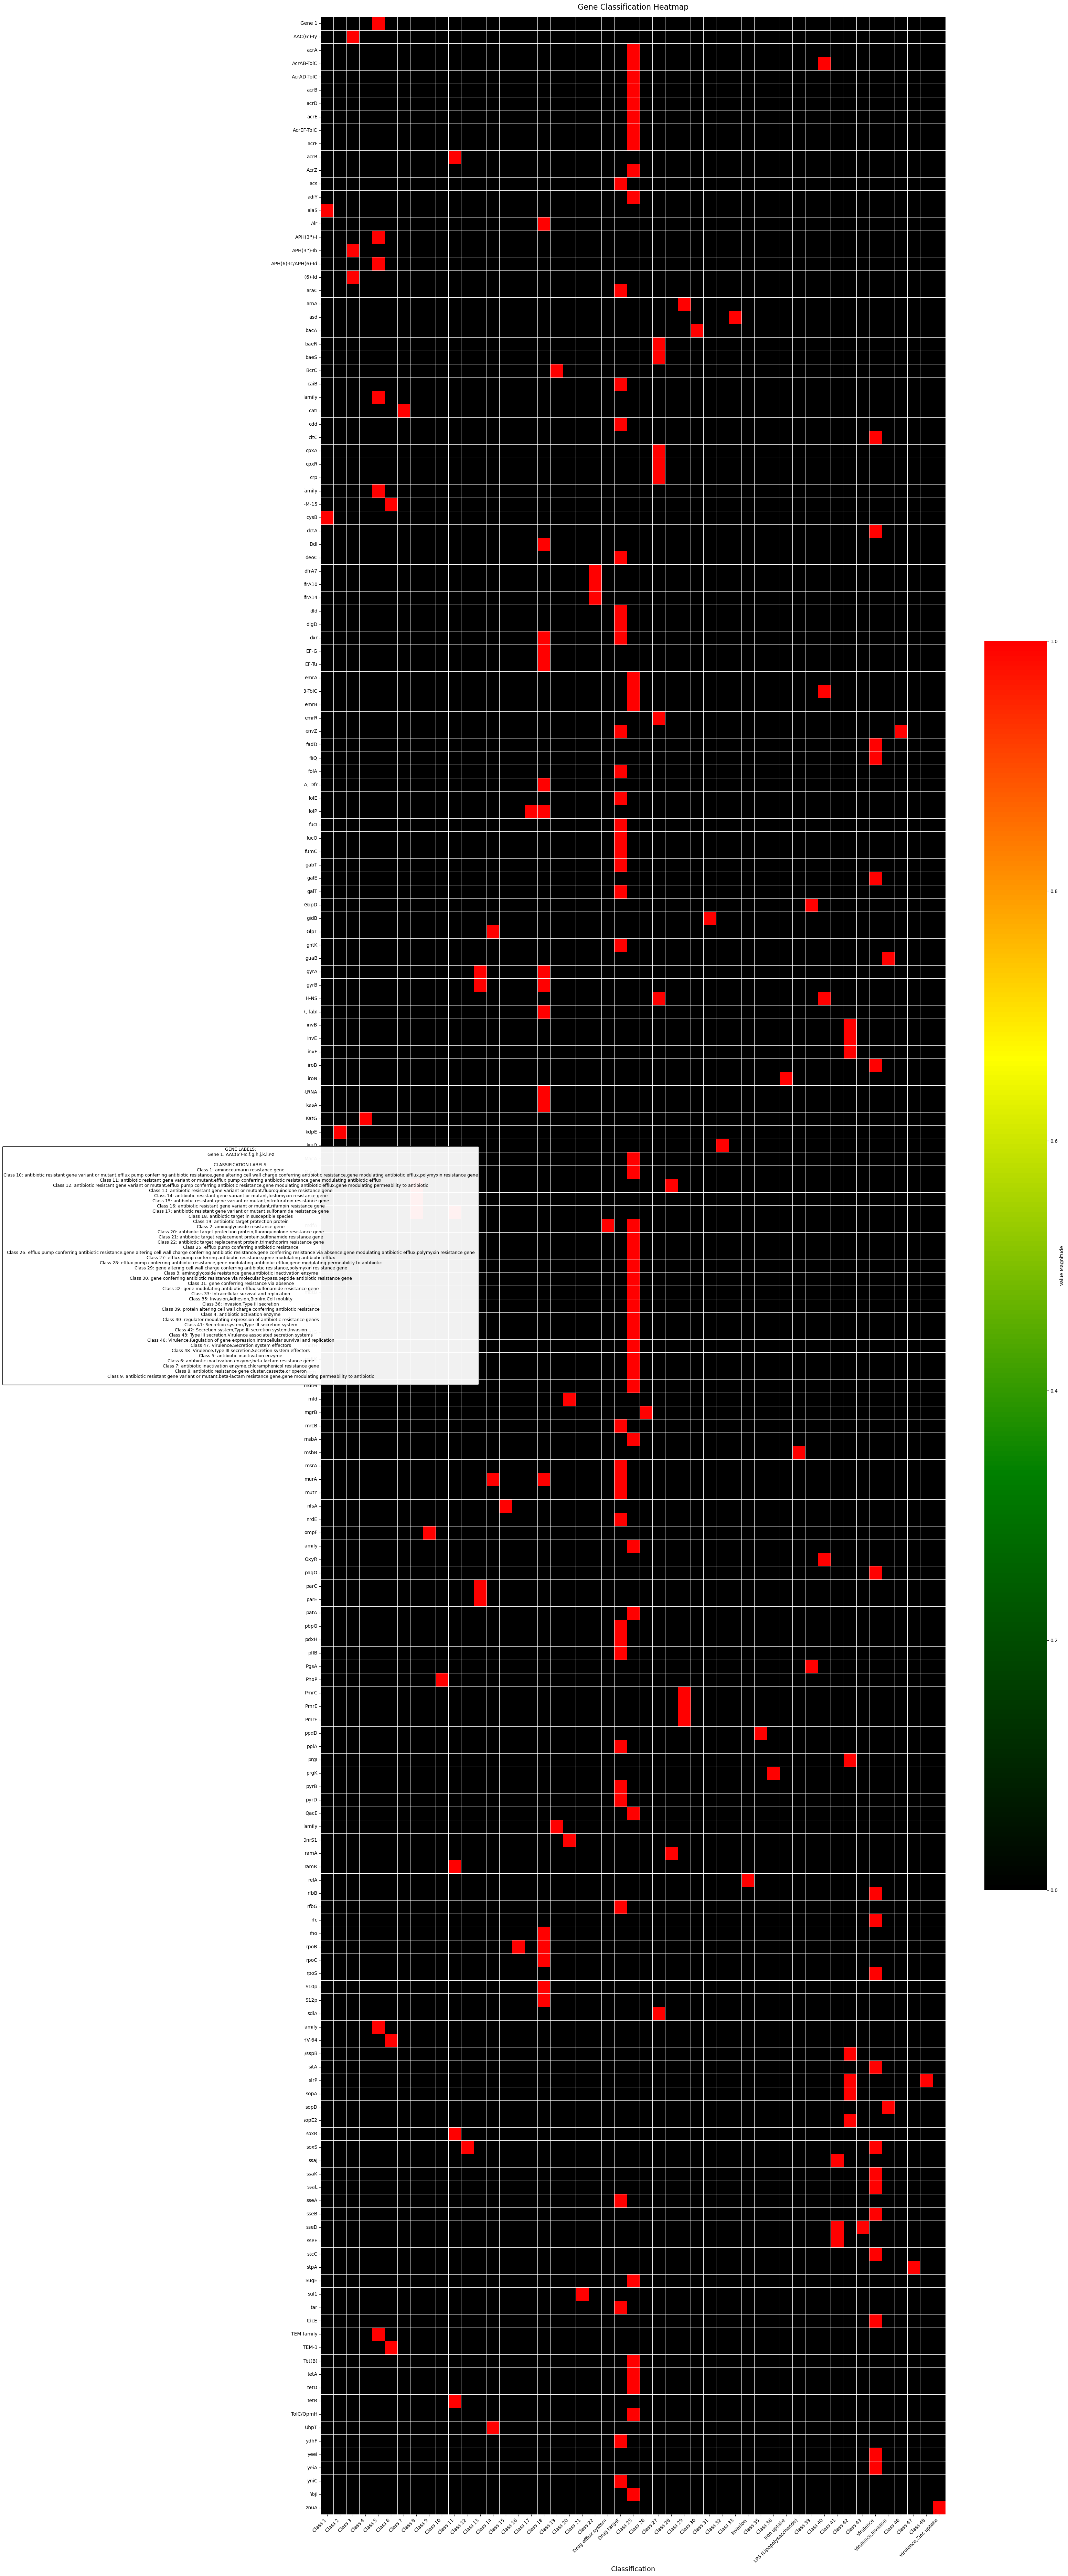

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
input_file = "datasets/Gene-Classification.csv"
output_heatmap = "GeneClassification_heatmap.png"
output_reference = "GeneClassification_reference.txt"
output_matrix_csv = "GeneClassification_matrix.csv"

# Data acquisition and preprocessing
print(f"Reading data from {input_file}...")
data = pd.read_csv(input_file)

# Examine data structure
print("Data preview:")
print(data.head())

# Determine the CSV structure
# Approach 1: If first row contains classifications as headers
if data.iloc[0, 0] == 'Gene':
    print("First row contains classification headers")
    # Extract classifications from the first row
    classifications = data.iloc[0, 1:].tolist()
    class_names = [str(cls) for cls in classifications]
    
    # Extract gene names from first column (excluding header row)
    genes = data.iloc[1:, 0].tolist()
    
    # Extract the numeric data (excluding the header row and first column)
    matrix_data = data.iloc[1:, 1:].values
    
    # Convert to numeric where possible, handling errors
    try:
        matrix_data = matrix_data.astype(float)
    except ValueError:
        # Alternative approach for mixed data types
        print("Warning: Mixed data types detected in matrix. Attempting conversion...")
        # Create a mask of convertible values
        mask = np.ones_like(matrix_data, dtype=bool)
        numeric_matrix = np.zeros_like(matrix_data, dtype=float)
        
        # Convert elements individually where possible
        for i in range(matrix_data.shape[0]):
            for j in range(matrix_data.shape[1]):
                try:
                    numeric_matrix[i,j] = float(matrix_data[i,j])
                except (ValueError, TypeError):
                    mask[i,j] = False
                    numeric_matrix[i,j] = 0  # Default value for non-convertible cells
        
        # Report conversion statistics
        print(f"Converted {np.sum(mask)}/{matrix_data.size} values to numeric format")
        matrix_data = numeric_matrix
    
# Approach 2: If first column is already gene names and columns are classifications
else:
    print("Data appears to be in standard format")
    # First column contains gene names
    genes = data.iloc[:, 0].tolist()
    
    # Column headers (excluding first) are classifications
    class_names = data.columns[1:].tolist()
    
    # Matrix data is everything except first column
    matrix_data = data.iloc[:, 1:].values
    
    # Convert to numeric where possible, handling errors
    try:
        matrix_data = matrix_data.astype(float)
    except ValueError:
        # Alternative approach for mixed data types
        print("Warning: Mixed data types detected in matrix. Attempting conversion...")
        # Create a mask of convertible values
        mask = np.ones_like(matrix_data, dtype=bool)
        numeric_matrix = np.zeros_like(matrix_data, dtype=float)
        
        # Convert elements individually where possible
        for i in range(matrix_data.shape[0]):
            for j in range(matrix_data.shape[1]):
                try:
                    numeric_matrix[i,j] = float(matrix_data[i,j])
                except (ValueError, TypeError):
                    mask[i,j] = False
                    numeric_matrix[i,j] = 0  # Default value for non-convertible cells
        
        # Report conversion statistics
        print(f"Converted {np.sum(mask)}/{matrix_data.size} values to numeric format")
        matrix_data = numeric_matrix

print(f"Extracted {len(genes)} genes and {len(class_names)} classifications")
print(f"Matrix shape: {matrix_data.shape}")

# Check for any data issues
try:
    # This may fail if data isn't all numeric
    non_zero_count = np.count_nonzero(matrix_data)
    print(f"Data contains {non_zero_count} non-zero values out of {matrix_data.size}")
    print(f"Unique values in data: {np.unique(matrix_data)[:10]}...")
except:
    print("Warning: Matrix contains non-numeric values")
    # Count non-zero/non-empty cells another way
    non_empty = np.sum(matrix_data != 0) if hasattr(matrix_data, 'shape') else sum(1 for x in matrix_data.flatten() if x != 0)
    print(f"Data contains {non_empty} non-zero/non-empty values")

# Handle long gene names by creating shortened names if needed
gene_label_mapping = {}
for idx, gene in enumerate(genes):
    if len(str(gene)) > 25:  # Threshold for truncation
        shortened = f"Gene {idx+1}"  # Numeric identifier
        gene_label_mapping[shortened] = str(gene)
        genes[idx] = shortened

# Handle long classification names by creating shortened names if needed
class_label_mapping = {}
for idx, cls in enumerate(class_names):
    if len(str(cls)) > 25:  # Threshold for truncation
        shortened = f"Class {idx+1}"  # Numeric identifier
        class_label_mapping[shortened] = str(cls)
        class_names[idx] = shortened

# Figure dimensioning with optimization for data volume
fig_width = max(20, len(class_names) * 0.5)
fig_height = max(14, len(genes) * 0.4)

# Create the heatmap visualization
print("\nGenerating heatmap visualization...")
plt.figure(figsize=(fig_width, fig_height))

# Try to convert data to DataFrame with appropriate handling of potential issues
try:
    heatmap_df = pd.DataFrame(matrix_data, index=genes, columns=class_names)
    
    # If data is not numeric, attempt to convert
    if not np.issubdtype(heatmap_df.dtypes[0], np.number):
        # Try to convert to numeric, coercing errors to NaN
        heatmap_df = heatmap_df.apply(pd.to_numeric, errors='coerce')
        
        # Replace NaN with 0 for visualization
        heatmap_df = heatmap_df.fillna(0)
        
        print("Converted non-numeric data to numeric format for visualization")
except Exception as e:
    print(f"Error creating dataframe: {e}")
    # Fallback: create a simplified dataframe
    print("Creating simplified dataframe for visualization")
    try:
        # Try to create a binary heatmap (0 = absent, 1 = present)
        binary_matrix = np.where(matrix_data != 0, 1, 0)
        heatmap_df = pd.DataFrame(binary_matrix, index=genes, columns=class_names)
    except:
        print("Severe data structure issue - attempting to visualize what we can")
        # Extract whatever subset of data we can work with
        max_genes = min(50, len(genes))  # Limit to 50 genes max
        max_classes = min(20, len(class_names))  # Limit to 20 classes max
        
        # Create a subset dataframe
        subset_matrix = np.zeros((max_genes, max_classes))
        heatmap_df = pd.DataFrame(
            subset_matrix, 
            index=genes[:max_genes], 
            columns=class_names[:max_classes]
        )
        print(f"Created subset visualization with {max_genes} genes and {max_classes} classifications")

# Custom color gradient: black for zero, green to red for increasing values
cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
    "custom", ["black", "green", "yellow", "red"], N=256
)

# Determine appropriate annotation parameters based on data size
show_annotations = len(genes) * len(class_names) <= 500  # Only show annotations for smaller matrices
annot_kws = {"size": 9} if len(genes) * len(class_names) <= 200 else {"size": 7}

# Generate the heatmap
heatmap = sns.heatmap(
    heatmap_df,
    cmap=cmap,
    cbar=True,
    square=False,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    linecolor='white',
    annot=show_annotations,
    fmt='.1g' if show_annotations else '',
    annot_kws=annot_kws if show_annotations else {},
    robust=True,
    cbar_kws={"shrink": 0.5, "label": "Value Magnitude"}
)

# Typography configuration
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)

# Title and labels
plt.title("Gene Classification Heatmap", fontsize=16, pad=15)
plt.xlabel('Classification', fontsize=14, labelpad=5)
plt.ylabel('Gene', fontsize=14, labelpad=1)

# Apply tight layout for the main heatmap without reserving space for legend
plt.tight_layout(pad=0.5)

# Add legend for truncated labels if any exist
if gene_label_mapping or class_label_mapping:
    legend_text = ""
    
    if gene_label_mapping:
        legend_text += "GENE LABELS:\n"
        for short, full in sorted(gene_label_mapping.items()):
            legend_text += f"{short}: {full}\n"
    
    if class_label_mapping:
        if legend_text:
            legend_text += "\n"
        legend_text += "CLASSIFICATION LABELS:\n"
        for short, full in sorted(class_label_mapping.items()):
            legend_text += f"{short}: {full}\n"
    
    # Create a new axes for the legend, positioning it exactly centered below the heatmap
    fig = plt.gcf()
    hm_ax = plt.gca()
    
    # Get the position of the heatmap axes
    hm_pos = hm_ax.get_position()
    
    # Calculate dimensions for legend box positioned to the left of the Y-axis
    legend_width = 0.15  # Fixed width for left-side legend
    legend_height = hm_pos.height * 0.8  # 80% of heatmap height
    
    # Create the legend axes positioned to the left of the Y-axis
    legend_ax = fig.add_axes([
        hm_pos.x0 - legend_width - 0.02,  # Position left of heatmap with small gap
        hm_pos.y0 + (hm_pos.height - legend_height) / 2,  # Centered vertically
        legend_width,
        legend_height
    ])
    
    # Remove axis ticks and spines for the legend box
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    
    # Add text to the legend axes with minimal padding
    legend_ax.text(0.5, 0.5, legend_text,
                  ha='center', va='center', 
                  fontsize=9,  # Reduced font size for compactness
                  multialignment='center',
                  transform=legend_ax.transAxes,
                  bbox={"facecolor":"white", "alpha":0.95, "pad":2, "boxstyle":"round,pad=0.2"})

# Save the heatmap
plt.savefig(output_heatmap, dpi=300, bbox_inches='tight', pad_inches=0.3)
print(f"Heatmap saved to {output_heatmap} with resolution 300 DPI")

# Generate auxiliary legend file for reference
with open(output_reference, 'w') as f:
    f.write("GENE CLASSIFICATION LABEL REFERENCE\n")
    f.write("=====================================\n\n")
    
    if gene_label_mapping:
        f.write("GENE LABELS:\n")
        for short, full in sorted(gene_label_mapping.items()):
            f.write(f"{short}: {full}\n")
    
    if class_label_mapping:
        f.write("\nCLASSIFICATION LABELS:\n")
        for short, full in sorted(class_label_mapping.items()):
            f.write(f"{short}: {full}\n")
    
    f.write("\nSTATISTICS:\n")
    f.write(f"Total genes: {len(genes)}\n")
    f.write(f"Total classifications: {len(class_names)}\n")
    try:
        f.write(f"Non-zero values: {np.count_nonzero(matrix_data)}\n")
        f.write(f"Percentage of non-zero values: {np.count_nonzero(matrix_data) / matrix_data.size * 100:.2f}%\n")
    except:
        f.write("Unable to calculate non-zero statistics due to data format\n")
    
    try:
        f.write(f"Value range: {np.min(matrix_data)} to {np.max(matrix_data)}\n")
    except:
        f.write("Unable to calculate value range due to data format\n")

# Export the heatmap data matrix to CSV for further analysis
print("\nExporting heatmap matrix data to CSV...")
heatmap_df.to_csv(output_matrix_csv)
print(f"Matrix data exported to {output_matrix_csv}")

print(f"Label reference file generated: {output_reference}")
print("\nHeatmap generation complete.")

Reading data from datasets/Gene-Classification.csv...
Data preview:
                   Unnamed: 0                 Classification  \
0                        Gene  aminocoumarin resistance gene   
1  AAC(6')-Ic,f,g,h,j,k,l,r-z                              0   
2                  AAC(6')-Iy                              0   
3                        acrA                              0   
4                  AcrAB-TolC                              0   

                       Unnamed: 2  \
0  aminoglycoside resistance gene   
1                               0   
2                               0   
3                               0   
4                               0   

                                          Unnamed: 3  \
0  aminoglycoside resistance gene,antibiotic inac...   
1                                                  0   
2                                                 32   
3                                                  0   
4                                           

C:\Users\Fatima\AppData\Local\Temp\ipykernel_26364\2752348397.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.issubdtype(heatmap_df.dtypes[0], np.number):


Heatmap saved to GeneClassification_heatmap.png with resolution 300 DPI

Exporting heatmap matrix data to CSV...
Matrix data exported to GeneClassification_matrix.csv
Label reference file generated: GeneClassification_reference.txt

Heatmap generation complete.


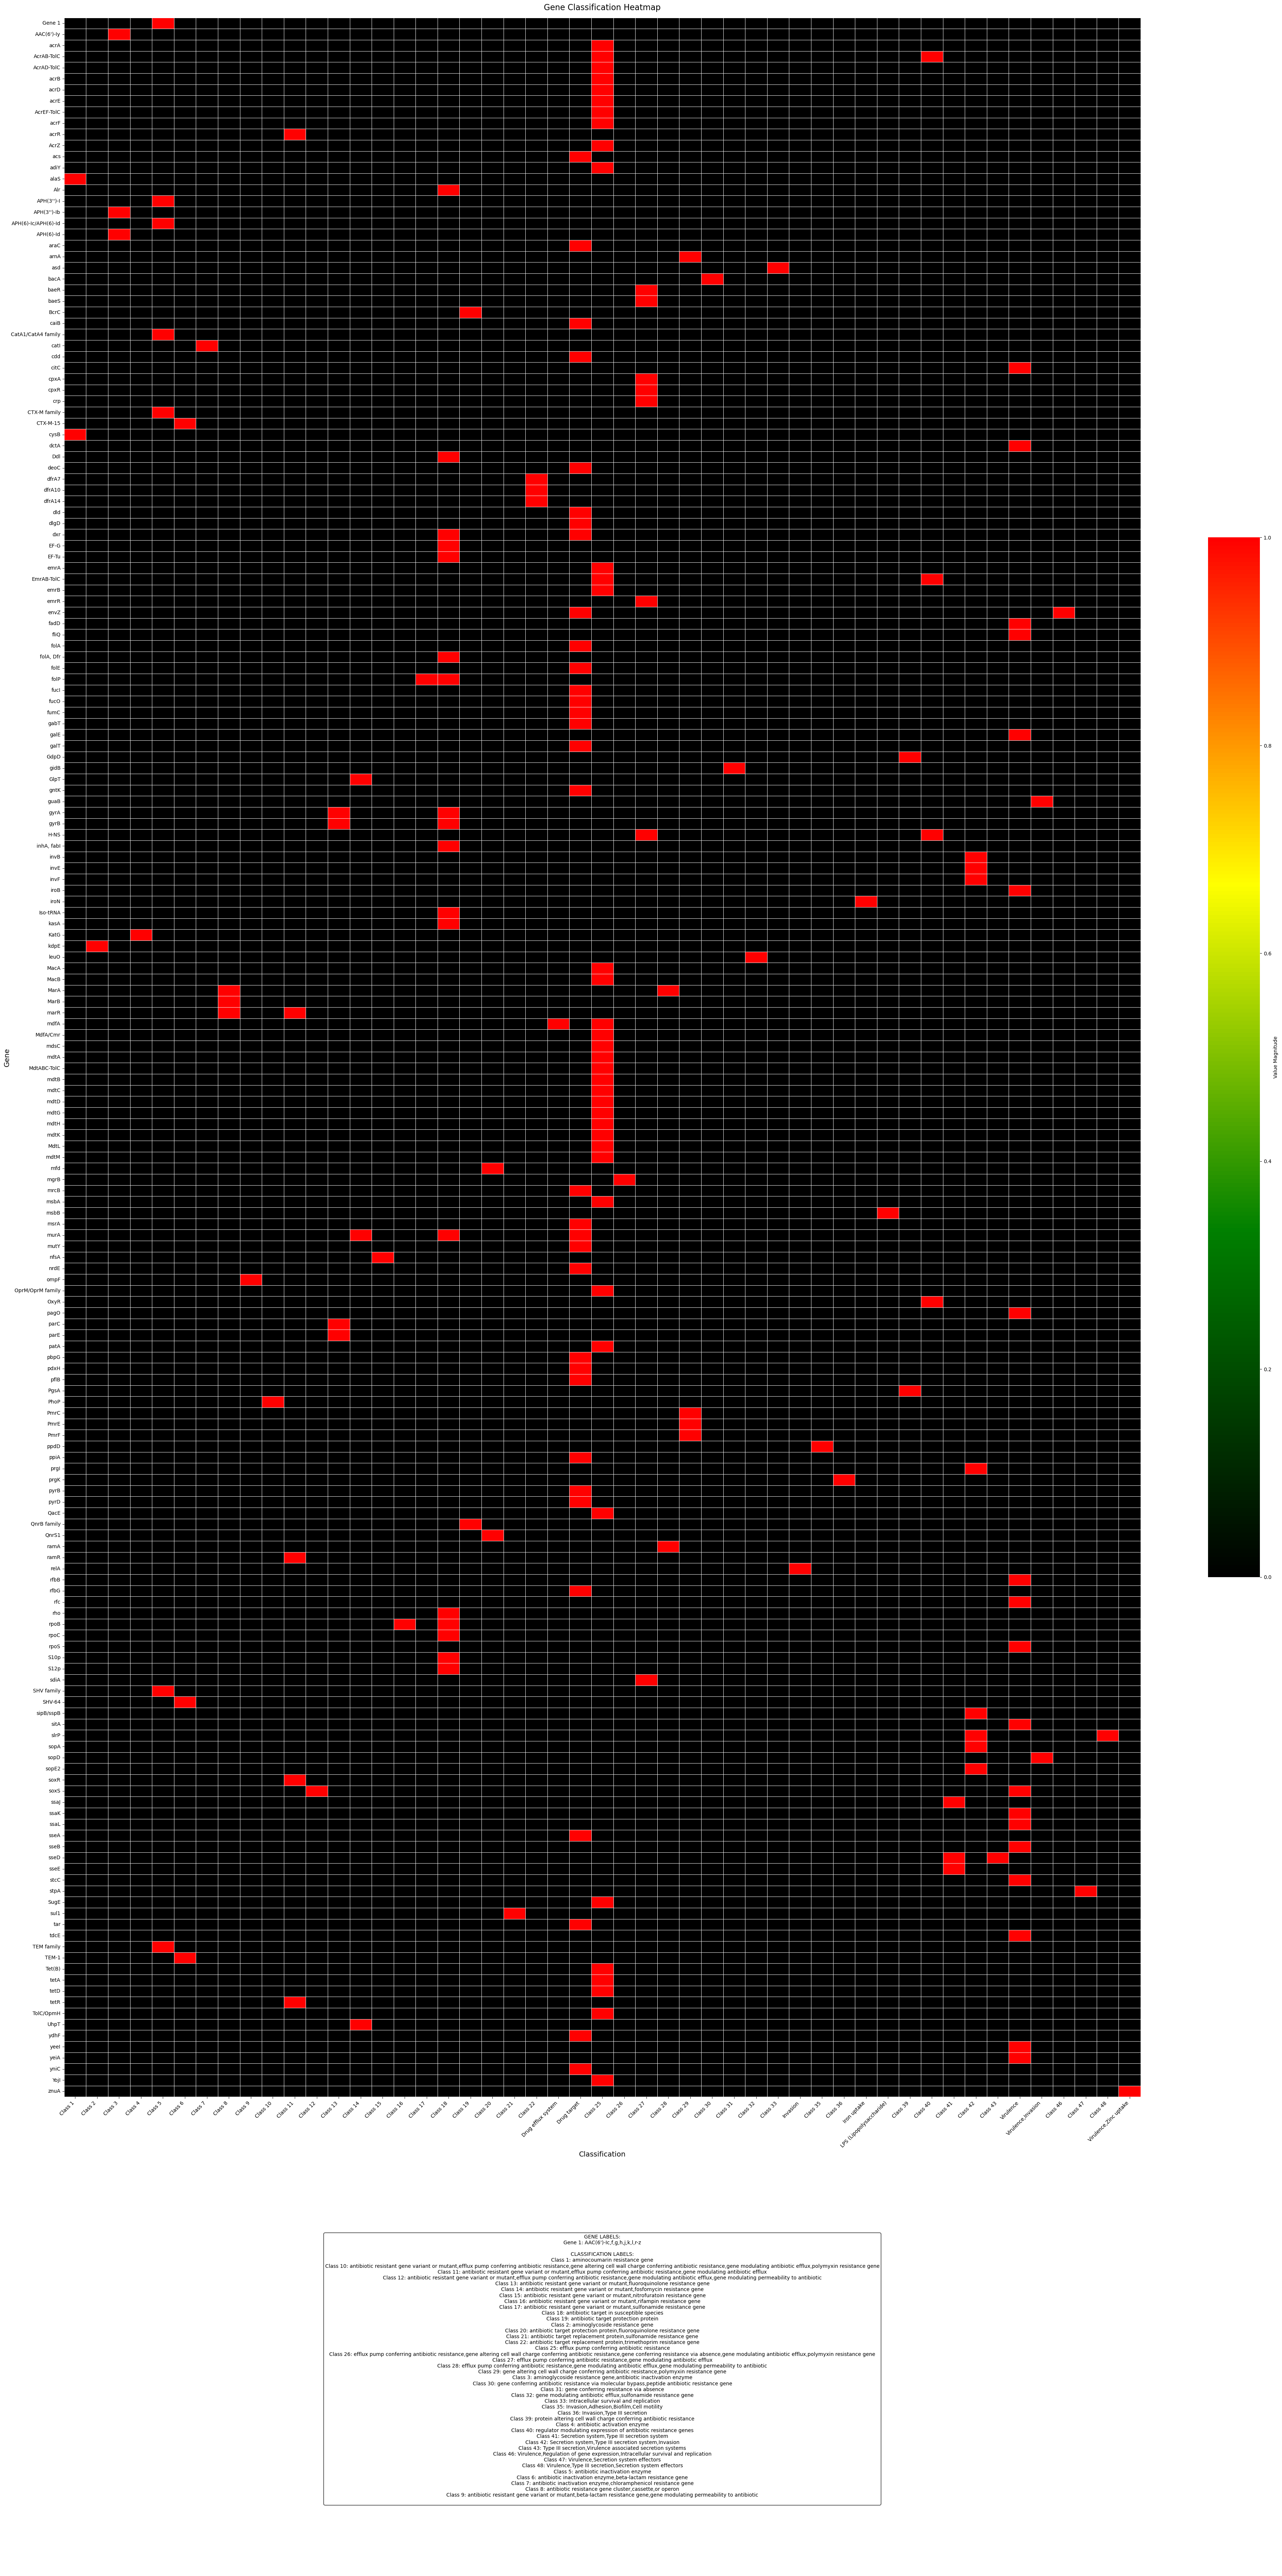

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
input_file = "datasets/Gene-Classification.csv"
output_heatmap = "GeneClassification_heatmap.png"
output_reference = "GeneClassification_reference.txt"
output_matrix_csv = "GeneClassification_matrix.csv"

# Data acquisition and preprocessing
print(f"Reading data from {input_file}...")
data = pd.read_csv(input_file)

# Examine data structure
print("Data preview:")
print(data.head())

# Determine the CSV structure
# Approach 1: If first row contains classifications as headers
if data.iloc[0, 0] == 'Gene':
    print("First row contains classification headers")
    # Extract classifications from the first row
    classifications = data.iloc[0, 1:].tolist()
    class_names = [str(cls) for cls in classifications]
    
    # Extract gene names from first column (excluding header row)
    genes = data.iloc[1:, 0].tolist()
    
    # Extract the numeric data (excluding the header row and first column)
    matrix_data = data.iloc[1:, 1:].values
    
    # Convert to numeric where possible, handling errors
    try:
        matrix_data = matrix_data.astype(float)
    except ValueError:
        # Alternative approach for mixed data types
        print("Warning: Mixed data types detected in matrix. Attempting conversion...")
        # Create a mask of convertible values
        mask = np.ones_like(matrix_data, dtype=bool)
        numeric_matrix = np.zeros_like(matrix_data, dtype=float)
        
        # Convert elements individually where possible
        for i in range(matrix_data.shape[0]):
            for j in range(matrix_data.shape[1]):
                try:
                    numeric_matrix[i,j] = float(matrix_data[i,j])
                except (ValueError, TypeError):
                    mask[i,j] = False
                    numeric_matrix[i,j] = 0  # Default value for non-convertible cells
        
        # Report conversion statistics
        print(f"Converted {np.sum(mask)}/{matrix_data.size} values to numeric format")
        matrix_data = numeric_matrix
    
# Approach 2: If first column is already gene names and columns are classifications
else:
    print("Data appears to be in standard format")
    # First column contains gene names
    genes = data.iloc[:, 0].tolist()
    
    # Column headers (excluding first) are classifications
    class_names = data.columns[1:].tolist()
    
    # Matrix data is everything except first column
    matrix_data = data.iloc[:, 1:].values
    
    # Convert to numeric where possible, handling errors
    try:
        matrix_data = matrix_data.astype(float)
    except ValueError:
        # Alternative approach for mixed data types
        print("Warning: Mixed data types detected in matrix. Attempting conversion...")
        # Create a mask of convertible values
        mask = np.ones_like(matrix_data, dtype=bool)
        numeric_matrix = np.zeros_like(matrix_data, dtype=float)
        
        # Convert elements individually where possible
        for i in range(matrix_data.shape[0]):
            for j in range(matrix_data.shape[1]):
                try:
                    numeric_matrix[i,j] = float(matrix_data[i,j])
                except (ValueError, TypeError):
                    mask[i,j] = False
                    numeric_matrix[i,j] = 0  # Default value for non-convertible cells
        
        # Report conversion statistics
        print(f"Converted {np.sum(mask)}/{matrix_data.size} values to numeric format")
        matrix_data = numeric_matrix

print(f"Extracted {len(genes)} genes and {len(class_names)} classifications")
print(f"Matrix shape: {matrix_data.shape}")

# Check for any data issues
try:
    # This may fail if data isn't all numeric
    non_zero_count = np.count_nonzero(matrix_data)
    print(f"Data contains {non_zero_count} non-zero values out of {matrix_data.size}")
    print(f"Unique values in data: {np.unique(matrix_data)[:10]}...")
except:
    print("Warning: Matrix contains non-numeric values")
    # Count non-zero/non-empty cells another way
    non_empty = np.sum(matrix_data != 0) if hasattr(matrix_data, 'shape') else sum(1 for x in matrix_data.flatten() if x != 0)
    print(f"Data contains {non_empty} non-zero/non-empty values")

# Handle long gene names by creating shortened names if needed
gene_label_mapping = {}
for idx, gene in enumerate(genes):
    if len(str(gene)) > 25:  # Threshold for truncation
        shortened = f"Gene {idx+1}"  # Numeric identifier
        gene_label_mapping[shortened] = str(gene)
        genes[idx] = shortened

# Handle long classification names by creating shortened names if needed
class_label_mapping = {}
for idx, cls in enumerate(class_names):
    if len(str(cls)) > 25:  # Threshold for truncation
        shortened = f"Class {idx+1}"  # Numeric identifier
        class_label_mapping[shortened] = str(cls)
        class_names[idx] = shortened

# Figure dimensioning with optimization for data volume
# Modified for increased width visualization
fig_width = max(30, len(class_names) * 0.8)  # Increased width multiplier and base value
fig_height = max(14, len(genes) * 0.4)  # Maintained height parameters

# Create the heatmap visualization
print("\nGenerating heatmap visualization...")
plt.figure(figsize=(fig_width, fig_height))

# Try to convert data to DataFrame with appropriate handling of potential issues
try:
    heatmap_df = pd.DataFrame(matrix_data, index=genes, columns=class_names)
    
    # If data is not numeric, attempt to convert
    if not np.issubdtype(heatmap_df.dtypes[0], np.number):
        # Try to convert to numeric, coercing errors to NaN
        heatmap_df = heatmap_df.apply(pd.to_numeric, errors='coerce')
        
        # Replace NaN with 0 for visualization
        heatmap_df = heatmap_df.fillna(0)
        
        print("Converted non-numeric data to numeric format for visualization")
except Exception as e:
    print(f"Error creating dataframe: {e}")
    # Fallback: create a simplified dataframe
    print("Creating simplified dataframe for visualization")
    try:
        # Try to create a binary heatmap (0 = absent, 1 = present)
        binary_matrix = np.where(matrix_data != 0, 1, 0)
        heatmap_df = pd.DataFrame(binary_matrix, index=genes, columns=class_names)
    except:
        print("Severe data structure issue - attempting to visualize what we can")
        # Extract whatever subset of data we can work with
        max_genes = min(50, len(genes))  # Limit to 50 genes max
        max_classes = min(20, len(class_names))  # Limit to 20 classes max
        
        # Create a subset dataframe
        subset_matrix = np.zeros((max_genes, max_classes))
        heatmap_df = pd.DataFrame(
            subset_matrix, 
            index=genes[:max_genes], 
            columns=class_names[:max_classes]
        )
        print(f"Created subset visualization with {max_genes} genes and {max_classes} classifications")

# Custom color gradient: black for zero, green to red for increasing values
cmap = plt.cm.colors.LinearSegmentedColormap.from_list(
    "custom", ["black", "green", "yellow", "red"], N=256
)

# Determine appropriate annotation parameters based on data size
show_annotations = len(genes) * len(class_names) <= 500  # Only show annotations for smaller matrices
annot_kws = {"size": 9} if len(genes) * len(class_names) <= 200 else {"size": 7}

# Generate the heatmap
heatmap = sns.heatmap(
    heatmap_df,
    cmap=cmap,
    cbar=True,
    square=False,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    linecolor='white',
    annot=show_annotations,
    fmt='.1g' if show_annotations else '',
    annot_kws=annot_kws if show_annotations else {},
    robust=True,
    cbar_kws={"shrink": 0.5, "label": "Value Magnitude"}
)

# Typography configuration optimized for wider visualization
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)

# Adjust figure layout to accommodate wider dimensions
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin for rotated labels

# Title and labels
plt.title("Gene Classification Heatmap", fontsize=16, pad=15)
plt.xlabel('Classification', fontsize=14, labelpad=5)
plt.ylabel('Gene', fontsize=14, labelpad=1)

# Apply tight layout but maintain space at bottom for legend if needed
# Modified to accommodate wider visualization
plt.tight_layout(pad=1.5, rect=[0, 0.2, 1, 1] if (gene_label_mapping or class_label_mapping) else [0, 0, 1, 1])

# Add legend for truncated labels if any exist
if gene_label_mapping or class_label_mapping:
    legend_text = ""
    
    if gene_label_mapping:
        legend_text += "GENE LABELS:\n"
        for short, full in sorted(gene_label_mapping.items()):
            legend_text += f"{short}: {full}\n"
    
    if class_label_mapping:
        if legend_text:
            legend_text += "\n"
        legend_text += "CLASSIFICATION LABELS:\n"
        for short, full in sorted(class_label_mapping.items()):
            legend_text += f"{short}: {full}\n"
    
    # Create a new axes for the legend, positioning it exactly centered below the heatmap
    fig = plt.gcf()
    hm_ax = plt.gca()
    
    # Calculate the legend box position
    hm_pos = hm_ax.get_position()
    legend_width = hm_pos.width * 0.8  # 80% of heatmap width
    legend_height = 0.15  # Fixed height for legend
    
    # Create the legend axes positioned below the heatmap, perfectly centered
    legend_ax = fig.add_axes([
        hm_pos.x0 + (hm_pos.width - legend_width) / 2,  # Centered x position
        0.05,  # Fixed bottom position
        legend_width,
        legend_height
    ])
    
    # Remove axis ticks and spines for the legend box
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    for spine in legend_ax.spines.values():
        spine.set_visible(False)
    
    # Add text to the legend axes
    legend_ax.text(0.5, 0.5, legend_text,
                  ha='center', va='center', 
                  fontsize=10,
                  multialignment='center',
                  transform=legend_ax.transAxes,
                  bbox={"facecolor":"white", "alpha":0.9, "pad":3, "boxstyle":"round,pad=0.3"})

# Save the heatmap
plt.savefig(output_heatmap, dpi=300, bbox_inches='tight', pad_inches=0.3)
print(f"Heatmap saved to {output_heatmap} with resolution 300 DPI")

# Generate auxiliary legend file for reference
with open(output_reference, 'w') as f:
    f.write("GENE CLASSIFICATION LABEL REFERENCE\n")
    f.write("=====================================\n\n")
    
    if gene_label_mapping:
        f.write("GENE LABELS:\n")
        for short, full in sorted(gene_label_mapping.items()):
            f.write(f"{short}: {full}\n")
    
    if class_label_mapping:
        f.write("\nCLASSIFICATION LABELS:\n")
        for short, full in sorted(class_label_mapping.items()):
            f.write(f"{short}: {full}\n")
    
    f.write("\nSTATISTICS:\n")
    f.write(f"Total genes: {len(genes)}\n")
    f.write(f"Total classifications: {len(class_names)}\n")
    try:
        f.write(f"Non-zero values: {np.count_nonzero(matrix_data)}\n")
        f.write(f"Percentage of non-zero values: {np.count_nonzero(matrix_data) / matrix_data.size * 100:.2f}%\n")
    except:
        f.write("Unable to calculate non-zero statistics due to data format\n")
    
    try:
        f.write(f"Value range: {np.min(matrix_data)} to {np.max(matrix_data)}\n")
    except:
        f.write("Unable to calculate value range due to data format\n")

# Export the heatmap data matrix to CSV for further analysis
print("\nExporting heatmap matrix data to CSV...")
heatmap_df.to_csv(output_matrix_csv)
print(f"Matrix data exported to {output_matrix_csv}")

print(f"Label reference file generated: {output_reference}")
print("\nHeatmap generation complete.")